In [1]:
import shap
import keras
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

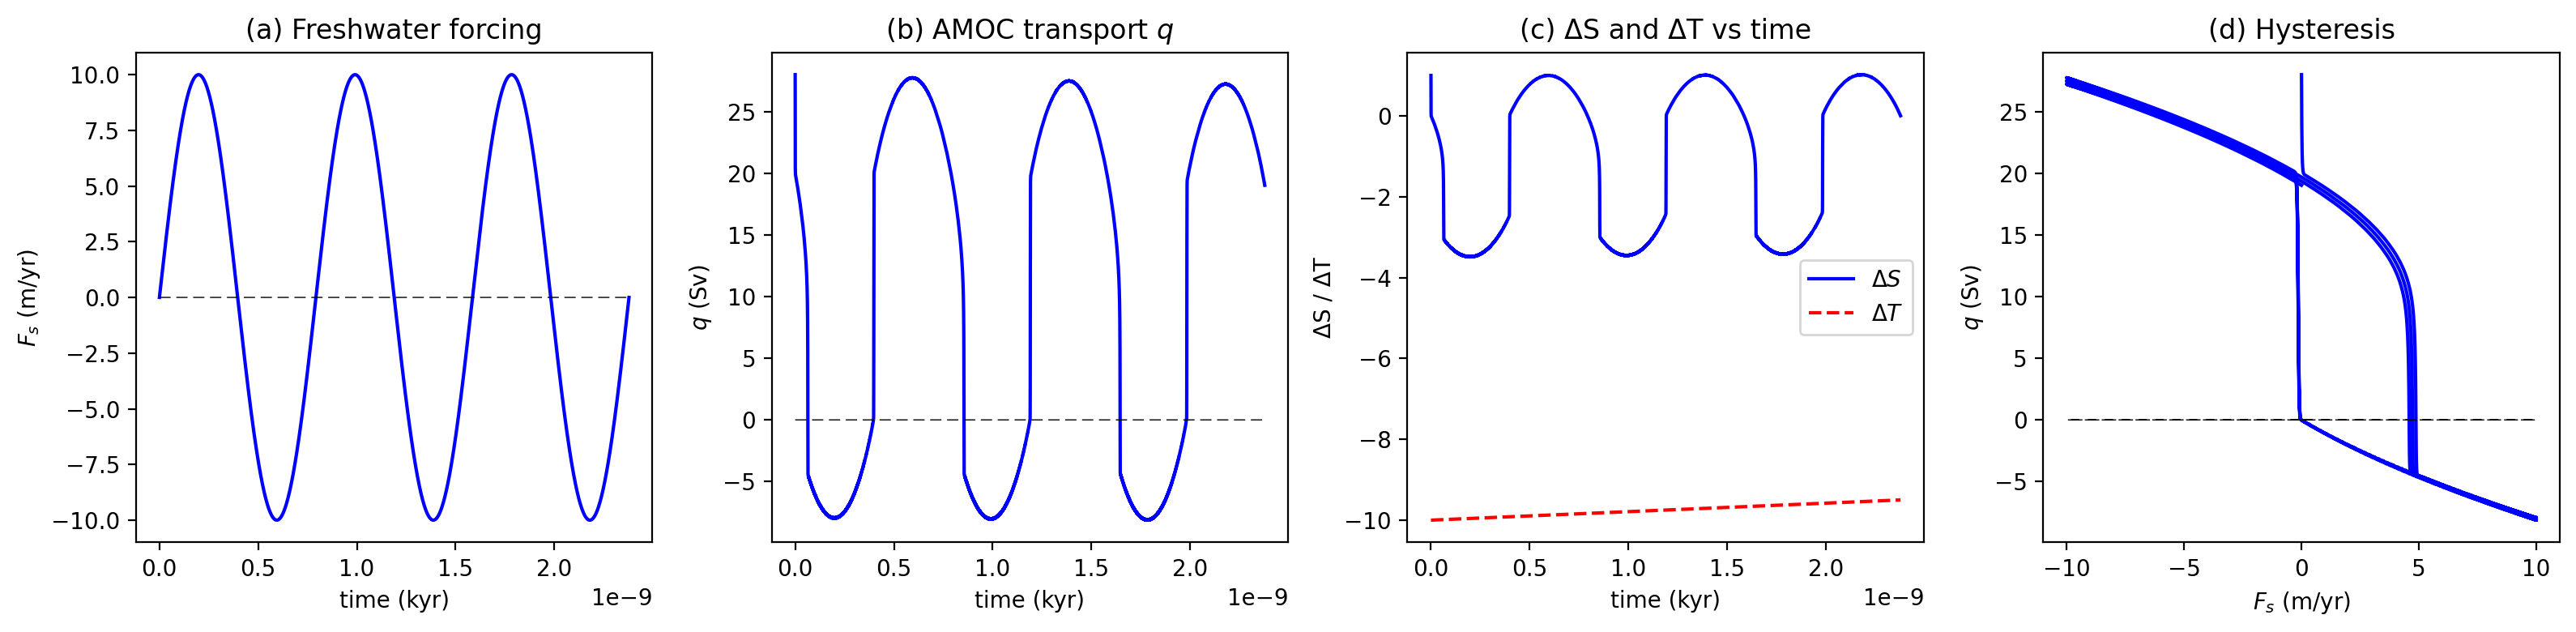

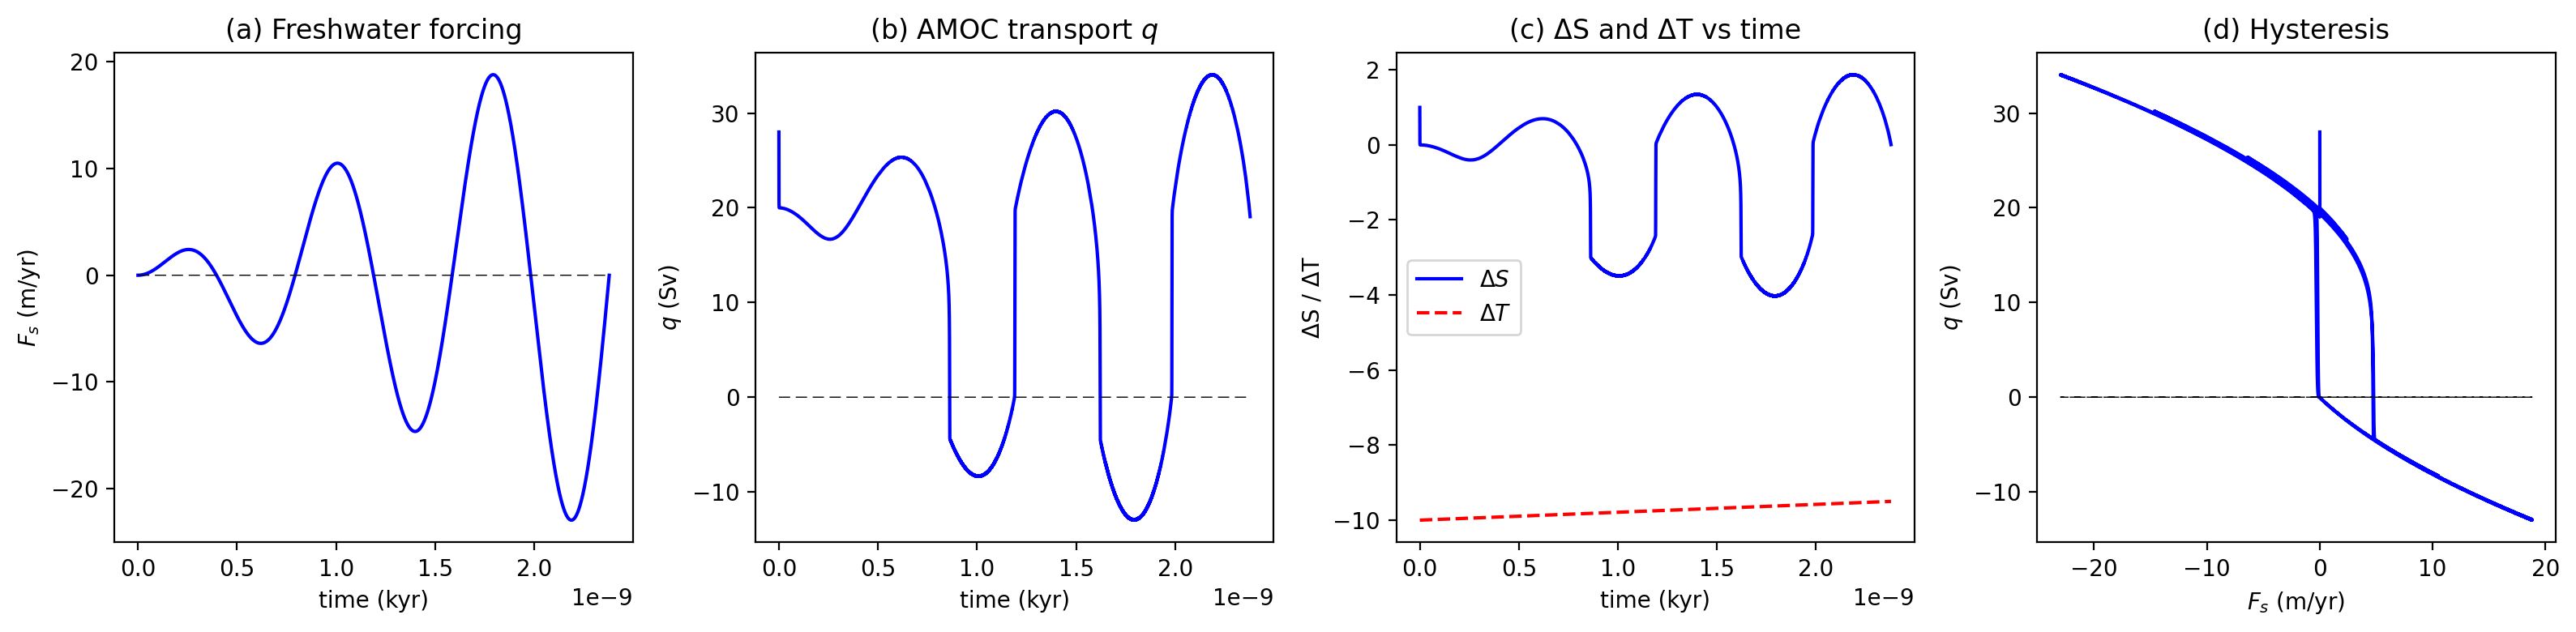

In [2]:
%run 00_generate_data.ipynb

In [3]:
input_data, output_data, qplot = get_data("s")

In [4]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

In [5]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 16
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [10]:
input_seq[0].shape

(16, 4)

In [11]:
def integrated_gradients(model, input_data, baseline=None, steps=50):
    """
    Compute integrated gradients for the given model and input.
    """
    if baseline is None:
        baseline = tf.zeros_like(input_data)
    
    # Generate alphas
    alphas = tf.linspace(0.0, 1.0, steps + 1)
    
    # Interpolate between baseline and input
    interpolated_inputs = []
    for alpha in alphas:
        interpolated = baseline + alpha * (input_data - baseline)
        interpolated_inputs.append(interpolated)
    
    interpolated_inputs = tf.stack(interpolated_inputs, axis=0)
    
    # Compute gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)
    
    gradients = tape.gradient(predictions, interpolated_inputs)
    
    # Average gradients and multiply by input difference
    avg_gradients = tf.reduce_mean(gradients, axis=0)
    integrated_grads = avg_gradients * (input_data - baseline)
    
    return integrated_grads

# Your modified loop
IG_list = []
for i in range(12):
    tf.keras.backend.clear_session()
    
    model = Sequential([
        LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),
        Dense(4, activation='relu'),
        Dense(2, activation='relu'),
        Dense(1, activation='linear')  # Use linear for better gradients
    ])
    
    model.load_weights(f'models/lstm/stationary/ensemble_member_{i}.keras')
    
    # Use native TensorFlow implementation
    input_tensor = tf.convert_to_tensor(input_seq[0], dtype=tf.float32)
    analysisIG = integrated_gradients(model, input_tensor)
    IG_list.append(analysisIG.numpy())
    
    print(f"Completed model {i}")

Completed model 0
Completed model 1
Completed model 2
Completed model 3
Completed model 4
Completed model 5
Completed model 6
Completed model 7
Completed model 8
Completed model 9
Completed model 10
Completed model 11


In [18]:
# Number of sequences available
num_sequences = input_seq.shape[0]

# Compute gradient for each sequence (using last value or mean)
qplot_smooth = qplot / Sv
seq_grad = np.array([
    np.mean(np.abs(np.gradient(qplot_smooth[i:i+time_steps])))
    for i in range(num_sequences)
])

# Sampling probabilities
seq_probs = seq_grad / seq_grad.sum()

# Sample start indices
sample_size = 250
sample_start_indices = np.random.choice(num_sequences, size=sample_size, replace=False, p=seq_probs)

# Extract sequences
input_samples = input_seq[sample_start_indices]
output_samples = output_seq[sample_start_indices]

In [24]:
def integrated_gradients(model, input_data, baseline=None, steps=16):
    """
    Compute integrated gradients for the given model and input.
    """
    if baseline is None:
        baseline = tf.zeros_like(input_data)
    
    # Generate alphas
    alphas = tf.linspace(0.0, 1.0, steps + 1)
    
    # Interpolate between baseline and input
    interpolated_inputs = []
    for alpha in alphas:
        interpolated = baseline + alpha * (input_data - baseline)
        interpolated_inputs.append(interpolated)
    
    interpolated_inputs = tf.stack(interpolated_inputs, axis=0)
    
    # Compute gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)
    
    gradients = tape.gradient(predictions, interpolated_inputs)
    
    # Average gradients and multiply by input difference
    avg_gradients = tf.reduce_mean(gradients, axis=0)
    integrated_grads = avg_gradients * (input_data - baseline)
    
    return integrated_grads

# Your sampling code (already done)
# Number of sequences available
num_sequences = input_seq.shape[0]
# Compute gradient for each sequence (using last value or mean)
qplot_smooth = qplot / Sv
seq_grad = np.array([
    np.mean(np.abs(np.gradient(qplot_smooth[i:i+time_steps])))
    for i in range(num_sequences)
])
# Sampling probabilities
seq_probs = seq_grad / seq_grad.sum()
# Sample start indices
sample_size = 250
sample_start_indices = np.random.choice(num_sequences, size=sample_size, replace=False, p=seq_probs)
# Extract sequences
input_samples = input_seq[sample_start_indices]
output_samples = output_seq[sample_start_indices]

print(f"Selected {len(sample_start_indices)} sequences based on gradient magnitude")
print(f"Sample indices range: {sample_start_indices.min()} to {sample_start_indices.max()}")
print(f"Input samples shape: {input_samples.shape}")

# Modified loop for your 250 selected samples
IG_list = []  # This will be a list of 12 ensemble members, each containing 250 samples

for i in range(12):
    print(f"Starting ensemble member {i}")
    tf.keras.backend.clear_session()
    
    model = Sequential([
        LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),
        Dense(4, activation='relu'),
        Dense(2, activation='relu'),
        Dense(1, activation='linear')  # Use linear for better gradients
    ])
    
    model.load_weights(f'models/lstm/stationary/ensemble_member_{i}.keras')
    
    # Store integrated gradients for all 250 samples for this model
    model_IG_list = []
    
    for sample_idx in range(sample_size):
        # Use your pre-selected samples instead of sequential indexing
        input_tensor = tf.convert_to_tensor(input_samples[sample_idx], dtype=tf.float32)
        
        # Compute integrated gradients for this sample
        analysisIG = integrated_gradients(model, input_tensor)
        model_IG_list.append(analysisIG.numpy())
        
        # Progress update every 50 samples
        if (sample_idx + 1) % 50 == 0:
            print(f"  Model {i}: Completed {sample_idx + 1}/{sample_size} samples")
    
    # Stack all samples for this model
    model_IG_list.append(model_IG_array)  # Shape: (250, 1, time_steps, features)
    #print(model_IG)
    #model_IG_array = np.squeeze(model_IG_array, axis=1)  # Remove batch dimension: (250, time_steps, features)
    
    IG_list.append(model_IG_array)
    print(f"Completed ensemble member {i}, shape: {model_IG_array.shape}")

# Convert to numpy array for easier manipulation
IG_array = np.array(IG_list)  # Shape: (12_models, 250_samples, time_steps, features)
print(f"Final IG array shape: {IG_array.shape}")

# Optional: Compute ensemble statistics
#ensemble_mean_IG = np.mean(IG_array, axis=0)  # Average across models: (250, time_steps, features)
#ensemble_std_IG = np.std(IG_array, axis=0)    # Standard deviation across models

# print(f"Ensemble mean IG shape: {ensemble_mean_IG.shape}")
# print(f"Ensemble std IG shape: {ensemble_std_IG.shape}")

# # Additional analysis with your sampling information
# print(f"\nSampling summary:")
# print(f"Original sequence indices: {sample_start_indices[:10]}...")  # Show first 10
# print(f"Gradient range of selected samples: {seq_grad[sample_start_indices].min():.6f} to {seq_grad[sample_start_indices].max():.6f}")
# print(f"Mean gradient of selected samples: {seq_grad[sample_start_indices].mean():.6f}")

# # You might want to save the sampling information too
# sampling_info = {
#     'sample_indices': sample_start_indices,
#     'sample_gradients': seq_grad[sample_start_indices],
#     'sample_probabilities': seq_probs[sample_start_indices],
#     'input_samples': input_samples,
#     'output_samples': output_samples
# }

# Save results if needed
# np.save('integrated_gradients_250_samples.npy', IG_array)
# np.save('ensemble_mean_IG.npy', ensemble_mean_IG)
# np.save('ensemble_std_IG.npy', ensemble_std_IG)
# np.save('sampling_info.npy', sampling_info)

Selected 250 sequences based on gradient magnitude
Sample indices range: 2 to 98094
Input samples shape: (250, 16, 4)
Starting ensemble member 0
  Model 0: Completed 50/250 samples
  Model 0: Completed 100/250 samples
  Model 0: Completed 150/250 samples
  Model 0: Completed 200/250 samples
  Model 0: Completed 250/250 samples
Completed ensemble member 0, shape: (250, 16, 4)
Starting ensemble member 1
  Model 1: Completed 50/250 samples
  Model 1: Completed 100/250 samples
  Model 1: Completed 150/250 samples
  Model 1: Completed 200/250 samples
  Model 1: Completed 250/250 samples
Completed ensemble member 1, shape: (250, 16, 4)
Starting ensemble member 2
  Model 2: Completed 50/250 samples
  Model 2: Completed 100/250 samples
  Model 2: Completed 150/250 samples
  Model 2: Completed 200/250 samples
  Model 2: Completed 250/250 samples
Completed ensemble member 2, shape: (250, 16, 4)
Starting ensemble member 3
  Model 3: Completed 50/250 samples
  Model 3: Completed 100/250 samples
  

In [29]:
IG_mean = np.array(IG_list).mean(axis=0).mean(axis=1)

In [30]:
IG_temp = IG_mean[:, 2]/max(IG_mean[:,2])
IG_sal = IG_mean[:, 1]/max(IG_mean[:,1])

In [31]:
print('min: ' + str(np.min(IG_sal-IG_temp)))
print('max: ' + str(np.max(IG_sal-IG_temp)))
print('mean: ' + str(np.mean(IG_sal-IG_temp)))
print('median: ' + str(np.median(IG_sal-IG_temp)))
print('std: ' + str(np.std(IG_sal-IG_temp)))

min: -56.851067
max: 0.9905545
mean: -17.268412
median: -4.448228
std: 19.565382


In [34]:
relevance_ratio.shape

(250,)

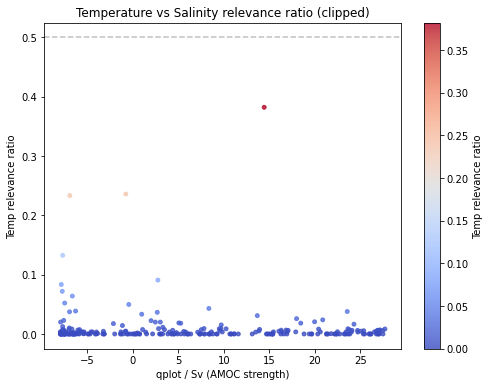

In [35]:
# Compute relevance ratio safely
epsilon = 1e-8
relevance_ratio = IG_temp / (IG_temp + IG_sal)

# Clip to [0, 1]
relevance_ratio = np.clip(relevance_ratio, 0, 1)

# Scatter plot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.figure(figsize=(8,6))
sc = plt.scatter(qplot[sample_start_indices]/Sv, relevance_ratio, c=relevance_ratio, cmap='coolwarm', s=15, alpha=0.8)
plt.colorbar(sc, label="Temp relevance ratio")
plt.axhline(0.5, color='grey', linestyle='--', alpha=0.5)  # equal contribution line
plt.xlabel("qplot / Sv (AMOC strength)")
plt.ylabel("Temp relevance ratio")
plt.title("Temperature vs Salinity relevance ratio (clipped)")

plt.show()


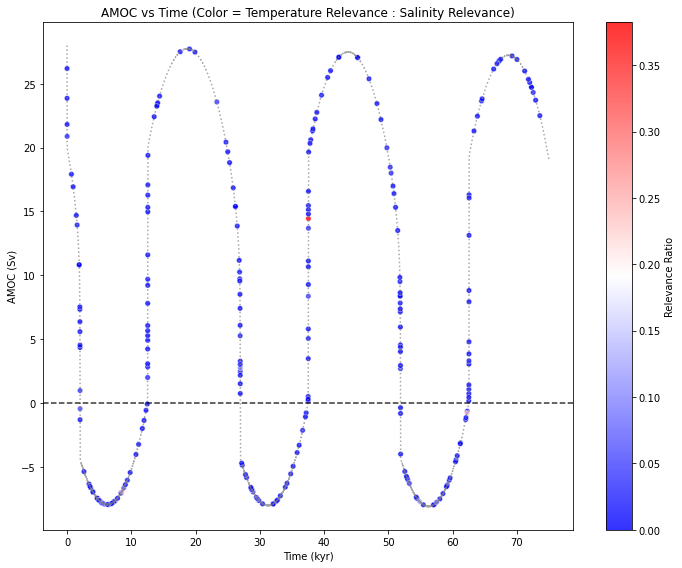

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))

# Background line
ax.plot(input_data[:,0], qplot/Sv, linestyle=':', color='grey', alpha=0.7)

# Color-coded scatter based on salinity - temperature LRP difference
color_values = relevance_ratio
scatter = ax.scatter(input_data[sample_start_indices, 0], qplot[sample_start_indices]/Sv, 
                    c=color_values, 
                    cmap='bwr',  # Red-Blue colormap (red=positive, blue=negative)
                    s=30, 
                    alpha=0.8,
                    edgecolors='white', 
                    linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Relevance Ratio')

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('AMOC vs Time (Color = Temperature Relevance : Salinity Relevance)')
ax.axhline(0, color='black', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

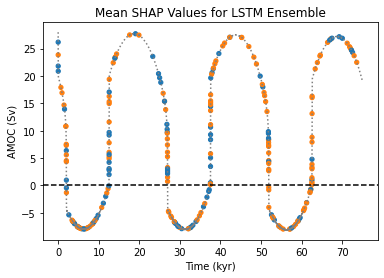

In [38]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(IG_temp > IG_sal, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(input_data[sample_start_indices, 0], qplot[sample_start_indices]/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean SHAP Values for LSTM Ensemble')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
#ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
 #         loc='lower right')

In [24]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=8):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)
        
    def forward(self, x):
        # x: (batch, time_steps, features)
        out, (h_n, c_n) = self.lstm(x)  # out: (batch, time_steps, hidden_size)
        out = out[:, -1, :]             # take last timestep (return_sequences=False)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        return out

In [7]:
def copy_lstm_weights(keras_lstm, pytorch_lstm):
    # keras weights
    kernel, recurrent_kernel, bias = keras_lstm.get_weights()
    # kernel: (input_size, 4*hidden_size)
    # recurrent_kernel: (hidden_size, 4*hidden_size)
    # bias: (4*hidden_size,)

    # PyTorch expects: (4*hidden_size, input_size) for weight_ih
    pytorch_lstm.weight_ih_l0.data = torch.from_numpy(kernel.T)
    pytorch_lstm.weight_hh_l0.data = torch.from_numpy(recurrent_kernel.T)
    # PyTorch splits bias into bias_ih + bias_hh (each half)
    half_bias = bias / 2.0
    pytorch_lstm.bias_ih_l0.data = torch.from_numpy(half_bias)
    pytorch_lstm.bias_hh_l0.data = torch.from_numpy(half_bias)


In [13]:
# -------------------------------
# Keras → PyTorch → LRP (Captum)
# -------------------------------

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import LayerLRP
import numpy as np

# -------------------------------
# 1️⃣ Load Keras model
# -------------------------------
keras_model_path = 'models/lstm/stationary/ensemble_member_0.keras'
keras_model = tf.keras.models.load_model(keras_model_path)
keras_model.summary()

# -------------------------------
# 2️⃣ Define PyTorch model
# -------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=8):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)
        
    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        return out

input_size = keras_model.input_shape[-1]  # number of features
model_pt = LSTMClassifier(input_size)
model_pt.eval()

# -------------------------------
# 3️⃣ Copy weights from Keras → PyTorch
# -------------------------------
# LSTM
def copy_lstm_weights(keras_lstm, pytorch_lstm):
    kernel, recurrent_kernel, bias = keras_lstm.get_weights()
    pytorch_lstm.weight_ih_l0.data = torch.from_numpy(kernel.T)
    pytorch_lstm.weight_hh_l0.data = torch.from_numpy(recurrent_kernel.T)
    half_bias = bias / 2.0
    pytorch_lstm.bias_ih_l0.data = torch.from_numpy(half_bias)
    pytorch_lstm.bias_hh_l0.data = torch.from_numpy(half_bias)

copy_lstm_weights(keras_model.layers[0], model_pt.lstm)

# Dense layers
def copy_dense_weights(keras_dense, pytorch_dense):
    weight, bias = keras_dense.get_weights()
    pytorch_dense.weight.data = torch.from_numpy(weight.T)
    pytorch_dense.bias.data = torch.from_numpy(bias)

copy_dense_weights(keras_model.layers[1], model_pt.fc1)
copy_dense_weights(keras_model.layers[2], model_pt.fc2)
copy_dense_weights(keras_model.layers[3], model_pt.fc3)

# -------------------------------
# 4️⃣ Compute LRP with Captum
# -------------------------------
# Example input: X_test (numpy) -> shape: (num_samples, time_steps, n_features)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Choose final layer to explain
layer_to_explain = model_pt.fc3
lrp = LayerLRP(model_pt, layer_to_explain)

# Compute per-feature relevance for the first batch
batch_size = 16
num_samples = X_test_tensor.shape[0]
all_relevance = torch.zeros_like(X_test_tensor)

for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    x_batch = X_test_tensor[start:end]
    relevance_batch = lrp.attribute(x_batch, target=0)  # target=0 or 1 for binary
    all_relevance[start:end] = relevance_batch

# Optional: sum over time steps to get per-feature relevance
per_feature_relevance = all_relevance.sum(dim=1).numpy()  # shape: (num_samples, n_features)
print("Per-feature relevance shape:", per_feature_relevance.shape)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 416       
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 465 (1.82 KB)
Trainable params: 465 (1.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


TypeError: Module of type <class 'torch.nn.modules.rnn.LSTM'> has no rule defined and nodefault rule exists for this module type. Please, set a ruleexplicitly for this module and assure that it is appropriatefor this type of layer.

In [ ]:
from captum.attr import LayerLRP

# Instantiate PyTorch model
input_size = n_features
model_pt = LSTMClassifier(input_size)
model_pt.eval()

# Choose a layer to explain (final Linear layer before sigmoid)
layer_to_explain = model_pt.fc3
lrp = LayerLRP(model_pt, layer_to_explain)

# Example input
x_sample = torch.tensor(X_test[0:1], dtype=torch.float32)  # shape: (1, time_steps, n_features)

# Compute relevance for class 1
attr = lrp.attribute(x_sample, target=0)  # target=0 if binary output

print(attr.shape)  # (1, time_steps, n_features)


In [10]:
import tf_explain
from tf_explain.core.integrated_gradients import IntegratedGradients
import numpy as np

explainer = IntegratedGradients()

# X_test: shape (num_samples, time_steps, n_features)
# class_index: output neuron you want to explain (0 or 1 for binary)
batch_size = 16  # you can adjust this depending on memory
num_samples = X_test_seq.shape[0]

# Initialize array to hold relevance for all sequences
all_relevance = np.zeros_like(X_test_seq)

# Loop through the test set in batches
for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    X_batch = X_test_seq[start:end]
    
    # TF-Explain expects (inputs, labels), labels can be None if just analyzing predictions
    relevance_batch = explainer.explain((X_batch, None), model, class_index=1)
    
    all_relevance[start:end] = relevance_batch

# Now all_relevance.shape == X_test.shape
# You can sum over time_steps if you want per-feature relevance only
per_feature_relevance = all_relevance.sum(axis=1)  # shape: (num_samples, n_features)

print("Per-feature relevance shape:", per_feature_relevance.shape)


ImportError: TF-explain requires Opencv. Install Opencv via `pip install opencv-python`

In [6]:
LRP_list = []

for i in range(12):
    tf.keras.backend.clear_session()
    
    model = Sequential([
        LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),
        Dense(4, activation='relu'),
        Dense(2, activation='relu'),
        Dense(1, activation='sigmoid')  # linear output for LRP
    ])
    
    # Load weights in-place (don't overwrite the model)
    model.load_weights(f'models/lstm/stationary/ensemble_member_{i}.keras')
    
    # For LRP, use pre-sigmoid logits, so swap the last activation to linear
    model.layers[-1].activation = tf.keras.activations.linear
    
    LRP_analyzer = LRPEpsilon(model)
    analysisLRP = LRP_analyzer.analyze(input_scaled)
    LRP_list.append(analysisLRP)
    
    print(i)


LRP is only tested for convolutional neural networks.
Check triggered by layers: [<keras.src.layers.rnn.lstm.LSTM object at 0x7fd789fab400>]


NotImplementedError: 

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# ----------------------------
# Enable eager execution
# ----------------------------
tf.config.run_functions_eagerly(True)

# ----------------------------
# LRP helper for Dense layers
# ----------------------------
def lrp_dense(a, w, b, R, epsilon=1e-6):
    """
    Layer-wise relevance propagation for a Dense layer using ε-rule.
    """
    z = tf.matmul(a, w) + b
    z += epsilon * tf.where(z >= 0, tf.ones_like(z), -tf.ones_like(z))
    s = R / z
    c = tf.matmul(s, tf.transpose(w))
    R_new = a * c
    return R_new

# ----------------------------
# LRP function for full model
# ----------------------------
def lrp_model(model, x):
    """
    Compute LRP for Sequential model with LSTM + Dense layers.
    x: tf.Tensor of shape (batch, time_steps, feature_dim)
    Returns: tf.Tensor of shape (batch, time_steps, feature_dim)
    """
    activations = [x]
    a = x
    for layer in model.layers:
        a = layer(a)
        activations.append(a)
    
    R = activations[-1]  # start from output

    # Backward pass
    for layer, a_prev in reversed(list(zip(model.layers, activations[:-1]))):
        if isinstance(layer, Dense):
            R = lrp_dense(a_prev, layer.kernel, layer.bias, R)
        elif isinstance(layer, LSTM):
            # Safe LSTM relevance distribution

            # Aggregate output relevance to scalar per sample
            R_sum = tf.reduce_sum(R, axis=-1, keepdims=True)  # (batch,1)

            # Distribute equally over timesteps
            batch_size, time_steps, feature_dim = a_prev.shape
            R_time = R_sum / time_steps  # (batch,1)

            # Distribute over features proportionally to absolute input
            abs_input = tf.abs(a_prev)
            abs_sum = tf.reduce_sum(abs_input, axis=-1, keepdims=True) + 1e-8
            R = R_time[..., tf.newaxis] * (abs_input / abs_sum)  # (batch, time_steps, feature_dim)
    
    return R

# ----------------------------
# Compute LRP for ensemble
# ----------------------------
LRP_list = []

for i in range(12):
    tf.keras.backend.clear_session()
    
    # Build model
    model = Sequential([
        LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),
        Dense(4, activation='relu'),
        Dense(2, activation='relu'),
        Dense(1, activation='linear')  # linear output for LRP
    ])
    
    model.load_weights(f'models/lstm/stationary/ensemble_member_{i}.keras')
    
    # Convert input to tf.Tensor
    x_input = tf.convert_to_tensor(input_seq, dtype=tf.float32)
    
    # Compute LRP
    analysis = lrp_model(model, x_input)
    
    # Convert to NumPy immediately
    LRP_list.append(analysis.numpy())
    
    print(f"Ensemble member {i} done")

# ----------------------------
# Stack into single NumPy array
# ----------------------------
LRP_array = np.stack(LRP_list, axis=0)  # shape: (n_models, batch, time_steps, feature_dim)
print("LRP array shape:", LRP_array.shape)


Ensemble member 0 done
Ensemble member 1 done
Ensemble member 2 done
Ensemble member 3 done
Ensemble member 4 done
Ensemble member 5 done
Ensemble member 6 done
Ensemble member 7 done
Ensemble member 8 done
Ensemble member 9 done
Ensemble member 10 done
Ensemble member 11 done
LRP array shape: (12, 99985, 16, 4)


In [34]:
LRP_mean = LRP_array.mean(axis=0).mean(axis=1)

In [35]:
LRP_mean.shape

(99985, 4)

In [36]:
LRP_mean

array([[0.2136551 , 0.11072738, 0.2136551 , 0.01022056],
       [0.2148494 , 0.10805332, 0.2148494 , 0.01024575],
       [0.21590574, 0.1056827 , 0.21590574, 0.01026396],
       ...,
       [0.21391055, 0.03468459, 0.21391055, 0.00464186],
       [0.21390967, 0.03467635, 0.21390967, 0.00462779],
       [0.21390879, 0.03466811, 0.21390879, 0.00461371]], dtype=float32)

In [37]:
lrp_temp = LRP_mean[:, 2]/max(LRP_mean[:,2])
lrp_sal = LRP_mean[:, 1]/max(LRP_mean[:,1])

In [38]:
print('min: ' + str(np.min(lrp_sal-lrp_temp)))
print('max: ' + str(np.max(lrp_sal-lrp_temp)))
print('mean: ' + str(np.mean(lrp_sal-lrp_temp)))
print('median: ' + str(np.median(lrp_sal-lrp_temp)))
print('std: ' + str(np.std(lrp_sal-lrp_temp)))

min: -0.9212735
max: 0.89618343
mean: -0.05586183
median: -0.0063031614
std: 0.453424


In [39]:
lrp_temp.shape

(99985,)

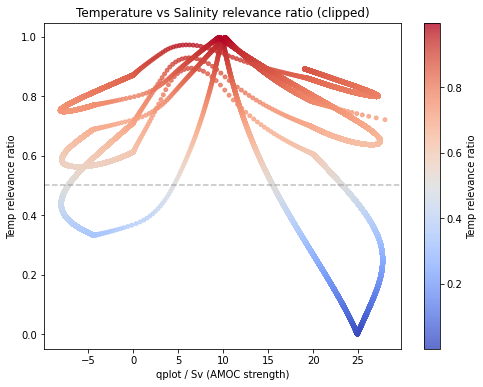

In [40]:
# Compute relevance ratio safely
epsilon = 1e-8
relevance_ratio = lrp_temp / (lrp_temp + lrp_sal)

# Clip to [0, 1]
relevance_ratio = np.clip(relevance_ratio, 0, 1)

# Scatter plot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.figure(figsize=(8,6))
sc = plt.scatter(qplot[0:99985]/Sv, relevance_ratio, c=relevance_ratio, cmap='coolwarm', s=15, alpha=0.8)
plt.colorbar(sc, label="Temp relevance ratio")
plt.axhline(0.5, color='grey', linestyle='--', alpha=0.5)  # equal contribution line
plt.xlabel("qplot / Sv (AMOC strength)")
plt.ylabel("Temp relevance ratio")
plt.title("Temperature vs Salinity relevance ratio (clipped)")

plt.show()


In [41]:
relevance_ratio

array([0.7214467 , 0.7274394 , 0.732777  , ..., 0.8922199 , 0.8922424 ,
       0.89226484], dtype=float32)

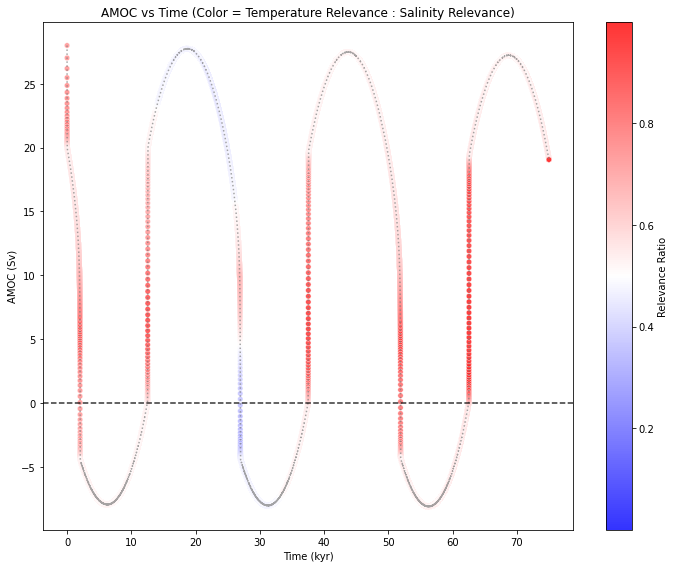

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

# Background line
ax.plot(input_data[:,0], qplot/Sv, linestyle=':', color='grey', alpha=0.7)

# Color-coded scatter based on salinity - temperature LRP difference
color_values = relevance_ratio
scatter = ax.scatter(input_data[0:99985, 0], qplot[0:99985]/Sv, 
                    c=color_values, 
                    cmap='bwr',  # Red-Blue colormap (red=positive, blue=negative)
                    s=30, 
                    alpha=0.8,
                    edgecolors='white', 
                    linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Relevance Ratio')

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('AMOC vs Time (Color = Temperature Relevance : Salinity Relevance)')
ax.axhline(0, color='black', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

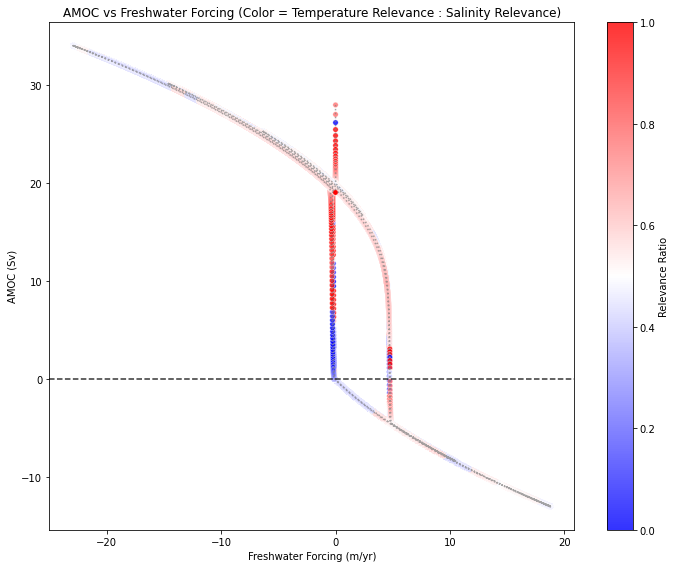

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

# Background line
ax.plot(input_data[:,3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey', alpha=0.7)

# Color-coded scatter based on salinity - temperature LRP difference
color_values = relevance_ratio
scatter = ax.scatter(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, 
                    c=color_values, 
                    cmap='bwr',  # Red-Blue colormap (red=positive, blue=negative)
                    s=30, 
                    alpha=0.8,
                    edgecolors='white', 
                    linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Relevance Ratio')

ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('AMOC vs Freshwater Forcing (Color = Temperature Relevance : Salinity Relevance)')
ax.axhline(0, color='black', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()